# Supervised generative PC

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thebuckleylab/jpc/blob/main/examples/supervised_generative_pc.ipynb)

This notebook demonstrates how to train a simple feedforward network with predictive coding to generate MNIST digits.

In [1]:
%%capture
!pip install torch==2.3.1
!pip install torchvision==0.18.1
!pip install matplotlib==3.0.0

In [2]:
import jpc

import jax
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn
import optax

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')  # ignore warnings

## Hyperparameters

We define some global parameters, including the network architecture, learning rate, batch size, etc.

In [3]:
SEED = 0

INPUT_DIM = 10
WIDTH = 300
DEPTH = 3
OUTPUT_DIM = 784
ACT_FN = "relu"

LEARNING_RATE = 1e-3
BATCH_SIZE = 64
MAX_T1 = 100
TEST_EVERY = 50
N_TRAIN_ITERS = 200

## Dataset

Some utils to fetch and plot MNIST.

In [4]:
def get_mnist_loaders(batch_size):
    train_data = MNIST(train=True, normalise=True)
    test_data = MNIST(train=False, normalise=True)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    return train_loader, test_loader


class MNIST(datasets.MNIST):
    def __init__(self, train, normalise=True, save_dir="data"):
        if normalise:
            transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.1307), std=(0.3081)
                    )
                ]
            )
        else:
            transform = transforms.Compose([transforms.ToTensor()])
        super().__init__(save_dir, download=True, train=train, transform=transform)

    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        img = torch.flatten(img)
        label = one_hot(label)
        return img, label


def one_hot(labels, n_classes=10):
    arr = torch.eye(n_classes)
    return arr[labels]


def plot_mnist_img_preds(imgs, labels, n_imgs=10):
    plt.figure(figsize=(20, 2))
    for i in range(n_imgs):
        plt.subplot(1, n_imgs, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imgs[i].reshape(28, 28), cmap=plt.cm.binary_r)
        plt.xlabel(jnp.argmax(labels, axis=1)[i], fontsize=16)
    plt.show()


## Network

For `jpc` to work, we need to provide a network with callable layers. This is easy to do with the PyTorch-like [`nn.Sequential()`](https://docs.kidger.site/equinox/api/nn/sequential/#equinox.nn.Sequential) in [equinox](https://github.com/patrick-kidger/equinox). For example, we can define a ReLU MLP with two hidden layers as follows

In [5]:
key = jax.random.PRNGKey(SEED)
key, *subkeys = jax.random.split(key, 4)
network = [
    nn.Sequential(
        [
            nn.Linear(10, 300, key=subkeys[0]),
            nn.Lambda(jax.nn.relu)
        ],
    ),
    nn.Sequential(
        [
            nn.Linear(300, 300, key=subkeys[1]),
            nn.Lambda(jax.nn.relu)
        ],
    ),
    nn.Linear(300, 784, key=subkeys[2]),
]

You can also use [`jpc.make_mlp()`](https://thebuckleylab.github.io/jpc/api/Utils/#jpc.make_mlp) to define a multi-layer perceptron (MLP) or fully connected network.

In [6]:
network = jpc.make_mlp(
    key,
    input_dim=INPUT_DIM,
    width=WIDTH,
    depth=DEPTH,
    output_dim=OUTPUT_DIM,
    act_fn=ACT_FN,
    use_bias=True
)
print(network)

[Sequential(
  layers=(
    Lambda(fn=Identity()),
    Linear(
      weight=f32[300,10],
      bias=f32[300],
      in_features=10,
      out_features=300,
      use_bias=True
    )
  )
), Sequential(
  layers=(
    Lambda(fn=<PjitFunction of <function relu at 0x117801bd0>>),
    Linear(
      weight=f32[300,300],
      bias=f32[300],
      in_features=300,
      out_features=300,
      use_bias=True
    )
  )
), Sequential(
  layers=(
    Lambda(fn=<PjitFunction of <function relu at 0x117801bd0>>),
    Linear(
      weight=f32[784,300],
      bias=f32[784],
      in_features=300,
      out_features=784,
      use_bias=True
    )
  )
)]


## Train and test

A PC network can be updated in a single line of code with [`jpc.make_pc_step()`](https://thebuckleylab.github.io/jpc/api/Training/#jpc.make_pc_step). Similarly, we can use [`jpc.test_generative_pc()`](https://thebuckleylab.github.io/jpc/api/Testing/#jpc.test_generative_pc) to compute the network accuracy. Note that these functions are already "jitted" for optimised performance. Below we simply wrap each of these functions in training and test loops, respectively. 

Note that to train in an unsupervised way, you would simply need to remove the `input` from [`jpc.make_pc_step()`](https://thebuckleylab.github.io/jpc/api/Training/#jpc.make_pc_step) and the `evaluate()` script. See [this example notebook](https://thebuckleylab.github.io/jpc/examples/unsupervised_generative_pc/).

In [7]:
def evaluate(key, layer_sizes, batch_size, network, test_loader, max_t1):
    test_acc = 0
    for _, (img_batch, label_batch) in enumerate(test_loader):
        img_batch, label_batch = img_batch.numpy(), label_batch.numpy()

        acc, img_preds = jpc.test_generative_pc(
            model=network,
            input=label_batch,
            output=img_batch,
            key=key,
            layer_sizes=layer_sizes,
            batch_size=batch_size,
            max_t1=max_t1
        )
        test_acc += acc

    avg_test_acc = test_acc / len(test_loader)

    return avg_test_acc, label_batch, img_preds


def train(
      key,
      input_dim,
      width,
      depth,
      output_dim,
      batch_size,
      network,
      lr,
      max_t1,
      test_every,
      n_train_iters
):
    layer_sizes = [input_dim] + [width]*(depth-1) + [output_dim]
    optim = optax.adam(lr)
    opt_state = optim.init(
        (eqx.filter(network, eqx.is_array), None)
    )
    train_loader, test_loader = get_mnist_loaders(batch_size)

    for iter, (img_batch, label_batch) in enumerate(train_loader):
        img_batch, label_batch = img_batch.numpy(), label_batch.numpy()

        result = jpc.make_pc_step(
            model=network,
            optim=optim,
            opt_state=opt_state,
            input=label_batch,
            output=img_batch,
            max_t1=max_t1
        )
        network, opt_state = result["model"], result["opt_state"]
        train_loss = result["loss"]
        if ((iter+1) % test_every) == 0:
            avg_test_acc, test_label_batch, img_preds = evaluate(
                key,
                layer_sizes,
                batch_size,
                network,
                test_loader,
                max_t1=max_t1
            )
            print(
                f"Train iter {iter+1}, train loss={train_loss:4f}, "
                f"avg test accuracy={avg_test_acc:4f}"
            )
            if (iter+1) >= n_train_iters:
                break

    plot_mnist_img_preds(img_preds, test_label_batch)
    return network


## Run

Train iter 50, train loss=0.312354, avg test accuracy=79.717545
Train iter 100, train loss=0.275381, avg test accuracy=83.794067
Train iter 150, train loss=0.293271, avg test accuracy=84.755608
Train iter 200, train loss=0.297628, avg test accuracy=84.785660


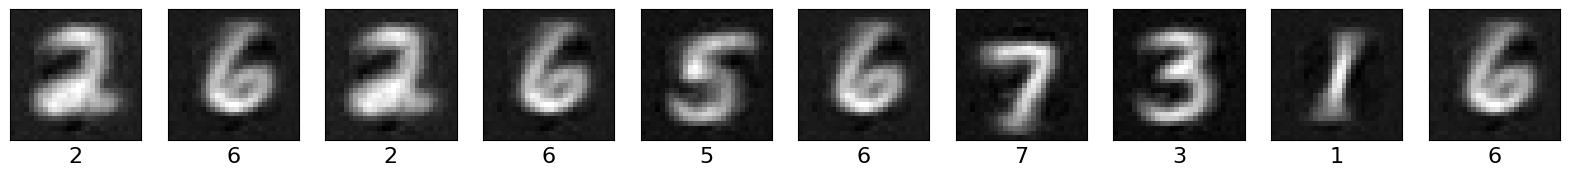

In [8]:
network = train(
    key=key,
    input_dim=INPUT_DIM,
    width=WIDTH,
    depth=DEPTH,
    output_dim=OUTPUT_DIM,
    batch_size=BATCH_SIZE,
    network=network,
    lr=LEARNING_RATE,
    max_t1=MAX_T1,
    test_every=TEST_EVERY,
    n_train_iters=N_TRAIN_ITERS
)